In [1]:
root_dir = '/home2/glee/dissertation/1_tech_gen_impact/class2class/Tech_Gen/'
master_dir = '/home2/glee/dissertation/1_tech_gen_impact/master/Tech_Gen/'
import sys
sys.path.append(root_dir)

import copy
import gc
import os
import argparse
import math
import time
import pickle
import re
import multiprocess as mp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
sys.path.append("/share/tml_package")
from tml import utils
from scipy import io
from tqdm import tqdm
from collections import OrderedDict

import torch
from torch.nn import functional as F
from torch.nn import DataParallel as DP
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from accelerate import Accelerator
import pytorch_model_summary

import optuna
from optuna.samplers import RandomSampler, TPESampler
from optuna.integration import SkoptSampler

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from data import TechDataset, CVSampler
from models import Transformer, Predictor
from train_utils import EarlyStopping, perf_eval, objective_cv, build_model, train_model, validate_model_mp
from utils import token2class, DotDict, to_device

from cleantext.sklearn import CleanTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# PART 1: Configuration

In [2]:
analysis_date = "2023-05-04_1802"
args = argparse.Namespace(
    do_eval = True,
    do_save=False,
    config_file=os.path.join(root_dir, "configs", "USED_configs", "[CONFIGS]"+analysis_date+".json"),
    eval_train_set=False)

project_data_dir = os.path.join(master_dir, "data")
data_dir = os.path.join("/home2/glee/patent_data/data/")
model_dir = os.path.join(root_dir, "models")
result_dir = os.path.join(root_dir, "results")
config_dir = os.path.join(root_dir, "configs")

## parse configuration file
# args = parser.parse_args()
if args.config_file is not None:
    config_file = args.config_file
else:
    config_file = os.path.join(config_dir, "configs_light.json") if args.light else os.path.join(config_dir, "configs.json")
if args.do_eval: args.do_train = False
configs = DotDict().load(config_file)
org_config_keys = {key: list(configs[key].keys()) for key in configs.keys()}

# parse command line arguments
instant_configs = {key: value for (key, value) in vars(args).items() if value is not None} # if any argument passed when main.py executed
instant_configs_for_update = {configkey: {key: value for (key,value) in instant_configs.items() if key in org_config_keys[configkey]} for configkey in org_config_keys.keys()}
for key, value in configs.items():
    value.update(instant_configs_for_update[key])

## assign loss weights
if configs.model.model_type == "enc-pred-dec":
    configs.train.loss_weights["recon"] = configs.train.loss_weights["recon"] / sum(configs.train.loss_weights.values())
    configs.train.loss_weights["y"] = 1 - configs.train.loss_weights["recon"]
elif configs.model.model_type == "enc-pred":
    configs.train.loss_weights = {"recon": 0, "y": 1}
elif configs.model.model_type == "enc-dec":
    configs.train.loss_weights = {"recon": 1, "y": 0}

## assign devices
if configs.train.use_accelerator:
    accelerator = Accelerator()
    device_ids = list(range(torch.cuda.device_count()))
    device = accelerator.device
    configs.train.update({"accelerator": accelerator})
else:
    if torch.cuda.is_available():
        device_ids = list(range(torch.cuda.device_count()))
        gpu_usages = [np.sum([float(usage.split("uses")[-1].replace(" ","").replace("MB","")) for usage in torch.cuda.list_gpu_processes(id).split("GPU memory") if not usage=="" and "no processes are running" not in usage]) for id in device_ids]
        device_ids = np.argsort(gpu_usages)[:configs.train.n_gpus]
        device_ids = list(map(lambda x: torch.device('cuda', x),list(device_ids)))
        device = device_ids[0] # main device
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')
        device_ids = []

## extract configurations for dataset
config_period = "["+"-".join([str(year) for year in configs.data.target_period])+"]"
config_ipcs = str(configs.data.target_ipc).replace("\'","").replace(" ","")
config_keywords = str(configs.data.target_keywords).replace("\'","").replace(" ","")

## update configurations
configs.data.update({"root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "result_dir": result_dir,
                        "pretrained_enc": configs.model.pretrained_enc,
                        "pretrained_dec": configs.model.pretrained_dec,
                        "data_nrows": None,
                        "data_file": "collection_" + "".join([config_keywords, config_ipcs, config_period]) + ".csv"})
configs.train.update({"device": device,
                        "device_ids": device_ids,
                        "root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "use_keywords": configs.data.use_keywords,
                        "early_stop_patience": int(0.3*configs.train.max_epochs)})
configs.model.update({"device": device,
                        "device_ids": device_ids,
                        "n_directions": 2 if configs.model.bidirec else 1,
                        "use_accelerator": configs.train.use_accelerator})

## Set hyperparameters for model training (To be TUNED)
if configs.train.do_train and configs.train.do_tune:
    n_layers = configs.model.n_layers = None
    d_embedding = configs.model.d_embedding = None
    d_enc_hidden = configs.model.d_enc_hidden = None
    d_pred_hidden = configs.model.d_pred_hidden = None
    learning_rate = configs.train.learning_rate = None
    batch_size = configs.train.batch_size = None
    config_name = "HPARAM_TUNING"
    final_model_path = None
else:
    n_layers = configs.model.n_layers
    d_embedding = configs.model.d_embedding
    d_enc_hidden = configs.model.d_enc_hidden
    d_pred_hidden = configs.model.d_pred_hidden
    d_latent = configs.model.d_latent

    ## set filename for model
    key_components = {"data": ["ipc_level", "max_seq_len_class", "max_seq_len_claim", "vocab_size"], "model": ["n_layers", "d_hidden", "d_pred_hidden", "d_latent", "d_embedding", "d_ff", "n_head", "d_head"], "train": ["learning_rate", "batch_size", "max_epochs"]}
    model_config_name = "".join([config_keywords, config_ipcs, config_period]) + "data"
    for key in ["model", "train"]:
        for component in key_components[key]:
            model_config_name += f"[{str(configs[key][component])}]{component}"
    final_model_path = os.path.join(model_dir, f"[MODEL]{model_config_name}.ckpt")

configs.train.update({"model_config_name": model_config_name, "final_model_path": final_model_path})


# PART 2: Dataset setting

In [3]:
''' PART 2: Dataset setting '''
tstart = time.time()
dataset_config_name = "".join([config_keywords, config_ipcs, config_period]) + "data"
for component in key_components["data"]:
    dataset_config_name += f"[{str(configs.data[component])}]{component}"
dataset_path = os.path.join(project_data_dir, "pickled_dataset", "[DATASET]"+dataset_config_name+".pickle")

if os.path.exists(dataset_path) and args.do_save is False:
    print("Load pickled dataset...")
    with open(dataset_path, "rb") as f:
        tech_dataset = pickle.load(f)   # Load pickled dataset if dataset with same configuration already saved
        if tech_dataset.pretrained_enc != configs.data.pretrained_enc or tech_dataset.pretrained_dec != configs.data.pretrained_dec:
            tech_dataset.pretrained_enc = configs.data.pretrained_enc
            tech_dataset.pretrained_dec = configs.data.pretrained_dec
            tech_dataset.tokenizers = tech_dataset.get_tokenizers()
        for tk in tech_dataset.tokenizers.values():
            if "vocab_size" not in dir(tk):
                tk.vocab_size = tk.get_vocab_size()
        tech_dataset.use_keywords = configs.data.use_keywords
        ## load saved rawdata
        if tech_dataset.rawdata is None:
            tech_dataset.rawdata = pd.read_csv(os.path.join(data_dir, configs.data.data_file), low_memory=False)
    print("Pickled dataset loaded")
else:
    print("Make dataset...")
    if args.debug:
        configs.data.update({"data_nrows": 1000})
        dataset_path += ".debug"
    tech_dataset = TechDataset(configs.data)
    if not args.debug:
        rawdata_for_save = copy.deepcopy(tech_dataset.rawdata)
        with open(dataset_path, "wb") as f:
            tech_dataset.rawdata = None
            pickle.dump(tech_dataset, f)
        tech_dataset.rawdata = rawdata_for_save
tend = time.time()
print(f"{np.round(tend-tstart,4)} sec elapsed for loading patents for class [{configs.data.target_ipc}]")

configs.model.update({"tokenizers": tech_dataset.tokenizers,
                    "n_enc_seq_claim": tech_dataset.max_seq_len_claim,
                    "n_dec_seq_claim": tech_dataset.max_seq_len_claim,
                    "n_enc_seq_class": tech_dataset.max_seq_len_class,
                    "n_dec_seq_class": tech_dataset.max_seq_len_class,
                    "n_outputs": 1 if configs.data.pred_type=="regression" else tech_dataset.n_outputs,
                    "i_padding": tech_dataset.tokenizers["class_enc"].pad_id})

Load pickled dataset...
Pickled dataset loaded
9.9419 sec elapsed for loading patents for class [['H01L', 'H10']]


## Inference

In [4]:
final_model_path

'/home2/glee/dissertation/1_tech_gen_impact/class2class/Tech_Gen/models/[MODEL][semiconductor,silicon,chip][H01L,H10][2007-2012]data[4]n_layers[32]d_hidden[8]d_pred_hidden[128]d_latent[128]d_embedding[16]d_ff[4]n_head[32]d_head[0.0005]learning_rate[256]batch_size[100]max_epochs.ckpt'

In [5]:
final_model = build_model(configs.model, tokenizers=tech_dataset.tokenizers)
if os.path.exists(final_model_path):
    best_states = torch.load(final_model_path)
else:
    raise Exception("Model need to be trained first")
converted_states = OrderedDict()
for k, v in best_states.items():
    if 'module' not in k:
        k = 'module.'+k
    else:
        k = k.replace('features.module.', 'module.features.')
    converted_states[k] = v
final_model.load_state_dict(converted_states)

del best_states
del converted_states
torch.cuda.empty_cache()
print("Model successfully loaded")

Model successfully loaded


In [6]:
result_path = os.path.join(root_dir, "results")

used_train_data = pd.read_excel(os.path.join(result_path, "[DATASET]"+analysis_date+".xlsx"), sheet_name="TRAIN_dataset")
used_test_data = pd.read_excel(os.path.join(result_path, "[DATASET]"+analysis_date+".xlsx"), sheet_name="TEST_dataset")
used_train_index = tech_dataset.data.index.get_indexer(pd.Index(used_train_data["number"]))
used_test_index = tech_dataset.data.index.get_indexer(pd.Index(used_test_data["number"]))

In [7]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [8]:
batch_size = 16

In [9]:
used_train_dataset = Subset(tech_dataset, used_train_index)
train_loader = DataLoader(used_train_dataset, batch_size=batch_size, drop_last=True)

In [10]:
zs, ys, preds = [], [], []
newzs = []
for batch_data in tqdm(train_loader):
    batch_data = to_device(batch_data, final_model.module.device)
    y = batch_data["targets"].cpu().detach().numpy()
    
    enc_outputs, z, mu, logvar = final_model.module.encode(batch_data["text_inputs"])
    pred_outputs = final_model.module.predictor(z)
    torch.cuda.empty_cache()

    zs.append(z.cpu().detach().numpy())
    ys.append(y)
    preds.append(pred_outputs.argmax(1).cpu().detach().numpy())
    
    torch.cuda.empty_cache()
                                                
zs = np.concatenate(zs)
ys = np.concatenate(ys)
preds = np.concatenate(preds)

100%|██████████| 2073/2073 [00:59<00:00, 34.84it/s]


In [11]:
import datetime
from nltk.translate.bleu_score import sentence_bleu
col_years = ["<1976"] + np.arange(1976,2023).astype(str).tolist()
latest_year = datetime.datetime.now().year - 1
n_TC = configs.data.n_TC

visualize = False

In [12]:
ref_config_period = "[2012-2017]"
ref_data_file = "collection_" + "".join([config_keywords, config_ipcs, ref_config_period]) + ".csv"
ref_configs = copy.deepcopy(configs)
ref_configs.data.update({"target_period": ref_config_period, "data_file": ref_data_file})
ref_dataset = TechDataset(ref_configs.data)




Tokenizer is trained and saved


In [13]:
ref_dataset.data_file

'collection_[semiconductor,silicon,chip][H01L,H10][2012-2017].csv'

In [14]:
used_rawdata = tech_dataset.rawdata.set_index("number")
total_data = pd.concat([tech_dataset.data, ref_dataset.data], axis=0)

In [15]:
tech_dataset.data["TC5"].quantile(0.9)

9.0

In [16]:
tech_dataset.data["TC5"].describe()

count    36865.000000
mean         3.994141
std         11.181469
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        873.000000
Name: TC5, dtype: float64

In [17]:
used_test_data["TC5"].describe()

count    3687.000000
mean        4.040955
std        10.007144
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max       217.000000
Name: TC5, dtype: float64

In [18]:
used_test_data_TC = used_test_data[used_test_data["TC5"]!=0].reset_index()

In [19]:
used_test_data_TC = used_test_data[used_test_data["TC5"]!=0].reset_index()
used_test_index_TC = tech_dataset.data.index.get_indexer(pd.Index(used_test_data_TC["number"]))

In [20]:
used_test_index_TC.shape

(2495,)

In [21]:
def breakdown(ipcs):
    return ([ipc[0] for ipc in ipcs], [ipc[:3] for ipc in ipcs], [ipc[:4] for ipc in ipcs], ipcs)

In [24]:
def validate_reliability(idx=None):
    cnt_nonexist = 0
    cnt_noFC = 0
    cnt_diverge = 0
    cnt_same_ipcs = 0
    
    input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
    input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[used_test_index_TC][idx])
    input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
    batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
    input_inf = to_device(batch_input, final_model.module.device)

    output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
    batch_output = {"text_outputs": torch.tensor(output_class)}
    output_inf = to_device(batch_output, final_model.module.device)

    near_mean_idx = np.argsort(np.sum(abs(zs - np.mean(zs, axis=0)), axis=1))[:2500]
    near_mean_idx_ = np.union1d(near_mean_idx, np.random.choice(np.where(ys==1)[0], 50))
    enc_outputs, z, mu, logvar = final_model.module.encode(input_inf)
    org_z = copy.deepcopy(z.view(1,-1).cpu().detach().numpy())
    pred_outputs = final_model.module.predict(z)
    org_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
    dec_inputs = None

    if used_test_data_TC.iloc[idx]["TC5"] > 0:
        forward_refs = used_rawdata.loc[used_test_data_TC.iloc[idx]["number"]]["forward_refs"].split(";")
        ref_info = total_data.loc[[ref for ref in forward_refs if ref in total_data.index]]
        if len(ref_info) == 0:
#             print("Dataset does not have information about citing patents")
            cnt_nonexist += 1
            return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None
        else:
            ref_ipcs = ref_info["ipcs"].apply(lambda x: set(x))
            ref_FCs = ref_info["TC"+str(n_TC)]

            tokenizer = tech_dataset.tokenizers["class_dec"]
            
            org_text = tokenizer.decode_batch(input_class.cpu().detach().numpy())[0]
            org_text = org_text[org_text.index(tokenizer.sos_token)+1:org_text.index(tokenizer.eos_token)]
            if set(org_text)==set(np.concatenate(ref_ipcs.apply(lambda x: list(x)).values)):
                cnt_same_ipcs += 1
#                 cnt_same_ipcs -= 1
#                 return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None
            
            n_iter = 50
            step_size = 10

            inclusions = [None, None, None, None]
            higher_impacts = [None, None, None, None]
            similar_refs_out = [None, None, None, None]
            unsimilar_refs_out = [None, None, None, None]
            optimised = False
            for i in range(n_iter):
                pred_outputs = final_model.module.predict(z)
                z.retain_grad()
                FC_estimated = np.round(np.exp(pred_outputs[0,1].item()), 4) # estimated forward citations
                
                FC_estimated_inv = np.round(np.exp(pred_outputs[0,0].item()), 4)
                pred_outputs[0,1].backward(retain_graph=True)

                grad_for_update = (step_size * z.grad)
                z_ = z + grad_for_update

                z.grad.zero_()
                dec_outputs = final_model.module.decode(z_, enc_outputs, dec_inputs=None)
                dec_outputs = dec_outputs.argmax(-1)

                tokenizer = tech_dataset.tokenizers["class_dec"]
                gen_text = tokenizer.decode_batch(dec_outputs.cpu().detach().numpy())[0]
                gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:gen_text.index(tokenizer.eos_token)]
                if gen_text != []:
                    gen_text = [gen_text[0]] + list(np.array(gen_text[1:])[np.unique(gen_text[1:], return_index=True)[1]])                
                    gen_text = set(gen_text)
                else: continue
                
#                 if not np.array_equal(org_text, gen_text) and FC_estimated>=0.5:
                if FC_estimated>=0.5:
#                 if not np.array_equal(org_text, gen_text):
#                 if set(org_text)!=set(gen_text) and FC_estimated>=0.5:
                    optimised = True
#                     print(f"<< Iteration {i+1} >>")
#                     print(f"Estimated prob. for L1 (L2): {FC_estimated} ({FC_estimated_inv})")
#                     print("Original class:\n",org_text,"\nGenerated class:\n", gen_text)
    
                    gen_text_breakdown = breakdown(gen_text)
                    ref_ipcs_breakdown = (ref_ipcs.apply(lambda x: breakdown(x)[0]), ref_ipcs.apply(lambda x: breakdown(x)[1]), ref_ipcs.apply(lambda x: breakdown(x)[2]), ref_ipcs)
            
                    for i in range(4):
                        if inclusions[i] is not None: continue
                        temp_gen_text = gen_text_breakdown[i]
                        temp_ref_ipcs = ref_ipcs_breakdown[i]
                    
                        hit_index = temp_ref_ipcs.apply(lambda x: 1 if set(x)==set(temp_gen_text) else 0)==1
                        similar_refs = temp_ref_ipcs[hit_index].index
                        similar_refs_out[i] = similar_refs
                        unsimilar_refs = temp_ref_ipcs[~hit_index].index
                        unsimilar_refs_out[i] = unsimilar_refs
                        if len(similar_refs) == 0:
                            inclusions[i] = 0
                            higher_impacts[i] = None
#                             print("Generated IPCs are not in citing patents' IPCs")
                        elif len(unsimilar_refs) == 0:
                            inclusions[i] = 1
                            similar_mean_FC = np.mean(ref_FCs.loc[similar_refs])
                            if similar_mean_FC <= 0:
                                higher_impacts[i] = 0
                            else:
                                higher_impacts[i] = 1
#                             print(f"similar patents' FCs: {np.round(similar_mean_FC, 4)}, no unsimilar patent")
                        else:
                            inclusions[i] = 1
                            similar_mean_FC = np.mean(ref_FCs.loc[similar_refs])
                            unsimilar_mean_FC = np.mean(ref_FCs.loc[unsimilar_refs])
                            if similar_mean_FC >= unsimilar_mean_FC:
                                if similar_mean_FC <= 0:
                                    higher_impacts[i] = None
                                else:
                                    higher_impacts[i] = 1
                            else:
                                higher_impacts[i] = 0
#                             print(f"similar patents' FCs: {np.round(similar_mean_FC, 4)}, unsimilar patents' FCs: {np.round(unsimilar_mean_FC, 4)}")
#                         if higher_impact==1:
#                             print(f"Generated IPCs have higher impact")
                    if None not in inclusions:
                        break
                z = z_
            if optimised:
                return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), {"index": idx, "patent_id": used_test_data_TC.iloc[idx]["number"], 
                         "org_text": org_text, "gen_text": gen_text, "ref_ipcs": ref_ipcs, "ref_FCs": ref_FCs,
                         "inclusions": inclusions, "higher_impacts": higher_impacts, 
                         "FC_estimated": FC_estimated,
                         "similar_refs": similar_refs_out, "unsimilar_refs": unsimilar_refs_out}
            else:
                cnt_diverge += 1
                return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None
    else:
        pass
#         print("Input patent does not have forward citation")
        cnt_noFC += 1
        return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None

In [25]:
cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs = 0, 0, 0, 0
dict_out = {"index": [], "patent_id": [], "org_text": [], "gen_text": [], "ref_ipcs": [], "ref_FCs": [],
            "inclusions": [], "higher_impacts": [], "FC_estimated": [], "similar_refs": [], "unsimilar_refs": []}
for idx in tqdm(range(len(used_test_index_TC))):
# for idx in tqdm(range(100)):
    cnts, results = validate_reliability(idx)
    cnt_nonexist += cnts[0]
    cnt_noFC += cnts[1]
    cnt_diverge += cnts[2]
    cnt_same_ipcs += cnts[3]
    
    if results is not None:
        for k,v in results.items():
#             if v is not None:
            dict_out[k].append(v)
    
for k, v in dict_out.items():
    dict_out[k] = np.array(v)

100%|██████████| 2495/2495 [15:51<00:00,  2.62it/s]


In [42]:
# dict_out_bck = copy.deepcopy(dict_out)

In [43]:
# analysis_date = "2023-05-04_1802"
# with open(f"../data/validation_out_{analysis_date}", "rb") as f:
#     dict_out_ = pickle.load(f)
dict_out = dict_out_ ## <- '2023-05-04_1802'

In [44]:
print("#total:",idx+1)
print("#valid data:",len(dict_out["index"]))
print("#nonexist data:",cnt_nonexist)
print("#no forward citations:",cnt_noFC)
print("#diverged:",cnt_diverge)
print("#same ipcs:",cnt_same_ipcs)
print("\n")
for i in range(4):
    inclusions = np.array(dict_out["inclusions"])[:,i]
    ratio_included = np.round(len(inclusions[inclusions==1])/len(inclusions), 4)
    higher_impacts = np.array(dict_out["higher_impacts"])[:,i][np.array(dict_out["higher_impacts"])[:,i] != None]
    ratio_higher_impact = np.round(len(higher_impacts[higher_impacts==1])/len(higher_impacts), 4)
    print(f"for level {i+1}, Ratio generated IPCs are included in citing patents: {ratio_included}")
    print(f"for level {i+1}, Ratio generated IPCs have higher impact than other citing patents: {ratio_higher_impact}")
    print("\n")

#total: 2495
#valid data: 1487
#nonexist data: 589
#no forward citations: 0
#diverged: 427
#same ipcs: 102


for level 1, Ratio generated IPCs are included in citing patents: 0.7216
for level 1, Ratio generated IPCs have higher impact than other citing patents: 0.6692


for level 2, Ratio generated IPCs are included in citing patents: 0.5965
for level 2, Ratio generated IPCs have higher impact than other citing patents: 0.6571


for level 3, Ratio generated IPCs are included in citing patents: 0.5387
for level 3, Ratio generated IPCs have higher impact than other citing patents: 0.6692


for level 4, Ratio generated IPCs are included in citing patents: 0.2044
for level 4, Ratio generated IPCs have higher impact than other citing patents: 0.5222




In [45]:
temp_inclusions = np.array(dict_out["inclusions"])[np.array(dict_out["inclusions"])[:,-1]==0]
for i in range(3):
    temp_ratio = len(temp_inclusions[temp_inclusions[:,i]==0]) / len(temp_inclusions)
    print(f"for level {i+1}, Hit ratio when level 4 is not hit: {np.round(temp_ratio,4)}")

for level 1, Hit ratio when level 4 is not hit: 0.35
for level 2, Hit ratio when level 4 is not hit: 0.5072
for level 3, Hit ratio when level 4 is not hit: 0.5799


In [46]:
from scipy.stats import ttest_ind
whole_patent_classes = tech_dataset.data["ipcs"].apply(lambda x: set(x))

hit_similar_FCs, hit_unsimilar_FCs, hit_diff_FCs = [], [], []
hit_similar_FCs_mean, hit_unsimilar_FCs_mean = [], []
hit_similar_FCs_rank = []
whole_FC_ttest = {"statistic": [], "pvalue": []}
whole_FCs_diff = []
hit_samples_index = dict_out["inclusions"][:,-1]==1

hit_patent_ids = dict_out["patent_id"][hit_samples_index]
hit_similar_refs = dict_out["similar_refs"][hit_samples_index][:,-1]
hit_unsimilar_refs = dict_out["unsimilar_refs"][hit_samples_index][:,-1]
for i in range(len(hit_patent_ids)):
    hit_FCs = dict_out["ref_FCs"][hit_samples_index][i]
    hit_similar_FC = hit_FCs.loc[hit_similar_refs[i]]
    hit_similar_FC_rank = hit_FCs.rank(pct=True).loc[hit_similar_refs[i]]
    hit_unsimilar_FC = hit_FCs.loc[hit_unsimilar_refs[i]]
    if len(hit_unsimilar_FC)>0:
        hit_diff_FC = hit_similar_FC.mean() - hit_unsimilar_FC.mean()
    else:
        hit_diff_FC = hit_similar_FC.mean()
    
    org_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["org_text"][hit_samples_index][i])].index]["TC5"]
    gen_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["gen_text"][hit_samples_index][i])].index]["TC5"]
    if len(org_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean() - org_whole_FC.mean()
    else:
        whole_FC_diff = gen_whole_FC.mean()
    
    hit_similar_FCs.append(hit_similar_FC)
    hit_similar_FCs_rank.append(hit_similar_FC_rank)
    hit_similar_FCs_mean.append(hit_similar_FC.mean())
    hit_unsimilar_FCs.append(hit_unsimilar_FC)
    if len(hit_unsimilar_FC)>0:
        hit_unsimilar_FCs_mean.append(hit_unsimilar_FC.mean())
    else:
        hit_unsimilar_FCs_mean.append(0)
    hit_diff_FCs.append(hit_diff_FC)
    
    ttest_res = ttest_ind(gen_whole_FC, org_whole_FC, equal_var=False)
#     if set(dict_out["org_text"][hit_samples_index][i]) != set(dict_out["gen_text"][hit_samples_index][i]):
#         print(org_whole_FC, gen_whole_FC)
#         print(ttest_res)
    
    whole_FC_ttest["statistic"].append(ttest_res.statistic)
    whole_FC_ttest["pvalue"].append(ttest_res.pvalue)
    if set(dict_out["org_text"][hit_samples_index][i]) != set(dict_out["gen_text"][hit_samples_index][i]):
        whole_FCs_diff.append(whole_FC_diff)
    
hit_similar_FCs = np.concatenate(hit_similar_FCs)
hit_similar_FCs_rank = np.concatenate(hit_similar_FCs_rank)
hit_similar_FCs_mean = np.array(hit_similar_FCs_mean)
hit_unsimilar_FCs = np.concatenate(hit_unsimilar_FCs)
hit_unsimilar_FCs_mean = np.array(hit_unsimilar_FCs_mean)
hit_diff_FCs = np.array(hit_diff_FCs)

print("Distribution of forward citations (hit)\n",pd.Series(hit_similar_FCs).describe(),"\n")
print("Distribution of forward citations (not hit)\n",pd.Series(hit_unsimilar_FCs).describe(),"\n")
print("Distribution of mean forward citations (hit)\n",pd.Series(hit_similar_FCs_mean).describe(),"\n")
print("Distribution of mean forward citations (not hit)\n",pd.Series(hit_unsimilar_FCs_mean).describe(),"\n")
print("Distribution of difference of forward citations\n",pd.Series(hit_diff_FCs).describe(),"\n")

Distribution of forward citations (hit)
 count    1038.000000
mean        7.099229
std        18.395074
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max       155.000000
dtype: float64 

Distribution of forward citations (not hit)
 count    3876.000000
mean       15.557018
std        34.779543
min         0.000000
25%         0.000000
50%         3.000000
75%         9.000000
max       274.000000
dtype: float64 

Distribution of mean forward citations (hit)
 count    304.000000
mean       6.371957
std       17.915391
min        0.000000
25%        0.000000
50%        2.000000
75%        5.000000
max      152.000000
dtype: float64 

Distribution of mean forward citations (not hit)
 count    304.000000
mean       6.010209
std       18.473987
min        0.000000
25%        0.000000
50%        1.781746
75%        4.537594
max      204.000000
dtype: float64 

Distribution of difference of forward citations
 count    304.000000
mean       0.361749
std  

In [48]:
ttest_ind(hit_similar_FCs_mean, hit_unsimilar_FCs_mean, equal_var=False)

Ttest_indResult(statistic=0.2450940877986594, pvalue=0.8064666318194484)

In [51]:
len(hit_similar_FCs[hit_similar_FCs>=tech_dataset.data["TC5"].quantile(0.9)]) / len(hit_similar_FCs)

0.1608863198458574

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

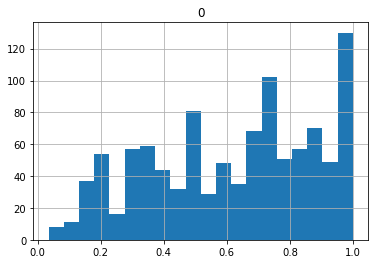

In [52]:
pd.DataFrame(hit_similar_FCs_rank).hist(bins=20)

In [53]:
from scipy.stats import ttest_ind
whole_FC_ttest = {"statistic": [], "pvalue": []}
whole_FCs_diff = []
for i in tqdm(range(len(dict_out["patent_id"]))):
    org_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["org_text"][i])].index]["TC5"]
    gen_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["gen_text"][i])].index]["TC5"]
    
#     print(org_whole_FC, gen_whole_FC)
    
    if len(org_whole_FC)>0 and len(gen_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean() - org_whole_FC.mean()
    elif len(org_whole_FC)==0 and len(gen_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean()
    elif len(org_whole_FC)>0 and len(gen_whole_FC)==0:
        whole_FC_diff = org_whole_FC.mean()
    else:
        whole_FC_diff = 0.0
    
    ttest_res = ttest_ind(gen_whole_FC, org_whole_FC, equal_var=False)
#     if set(dict_out["org_text"][hit_samples_index][i]) != set(dict_out["gen_text"][hit_samples_index][i]):
#         print(org_whole_FC, gen_whole_FC)
#         print(ttest_res)
    if set(dict_out["org_text"][i]) != set(dict_out["gen_text"][i]):    
        whole_FC_ttest["statistic"].append(ttest_res.statistic)
        whole_FC_ttest["pvalue"].append(ttest_res.pvalue)
        if set(dict_out["org_text"][i]) != set(dict_out["gen_text"][i]):
            whole_FCs_diff.append(whole_FC_diff)

100%|██████████| 1487/1487 [00:10<00:00, 142.05it/s]


In [57]:
np.mean(whole_FCs_diff)

0.32290674186758495